# Project Overview

## Context
<p> This data set is created only for the learning purpose of the customer segmentation concepts, also known as market basket analysis. </p>

## Problem Statement
<p> You are owing a supermarket mall and through membership cards, you have some basic data about your customers and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly. </p>

## Data Sets

The data is contained in one file:

* Mall_Costumers.csv - demographic data for each costumer and score

Here is the schema and explanation of each variable in the file:
* CostumerID - costumer id
* Gender - costumer gender
* Age - age of the costumer
* Annual Income (k$) - costumer's annual income
* Spending Score (1-100) - costumer's score based on behavior and purchansing data (higher the score, higher will be the customer expense)

# Libraries

In [182]:
# import libraries
import pandas as pd
import numpy as np

import math

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder

# plot
import seaborn as sns
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Reading

In [183]:
# read in the json files
df = pd.read_csv('data/Mall_Customers.csv')

In [184]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Data processing

In [185]:
# changing column names
df = df.rename(columns=
               {'CustomerID': 'USER_ID',
                'Gender': 'GENDER',
                'Age': 'AGE', 
                'Annual Income (k$)': 'ANNUAL_INCOME', 
                'Spending Score (1-100)': 'SPENDING_SCORE'})

#create age group column
df['AGE_GROUP'] = pd.cut(df['AGE'], 
                         bins=[17, 30, 40, 50, 60, 70],
                         labels=['18-30', '31-40', '41-50', '51-60', '61+'])

In [186]:
df.head()

,USER_ID,GENDER,AGE,ANNUAL_INCOME,SPENDING_SCORE,AGE_GROUP
0,1,Male,19,15,39,18-30
1,2,Male,21,15,81,18-30
2,3,Female,20,16,6,18-30
3,4,Female,23,16,77,18-30
4,5,Female,31,17,40,31-40


# Data Anaylsis

In [187]:
df.describe()

,USER_ID,AGE,ANNUAL_INCOME,SPENDING_SCORE
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


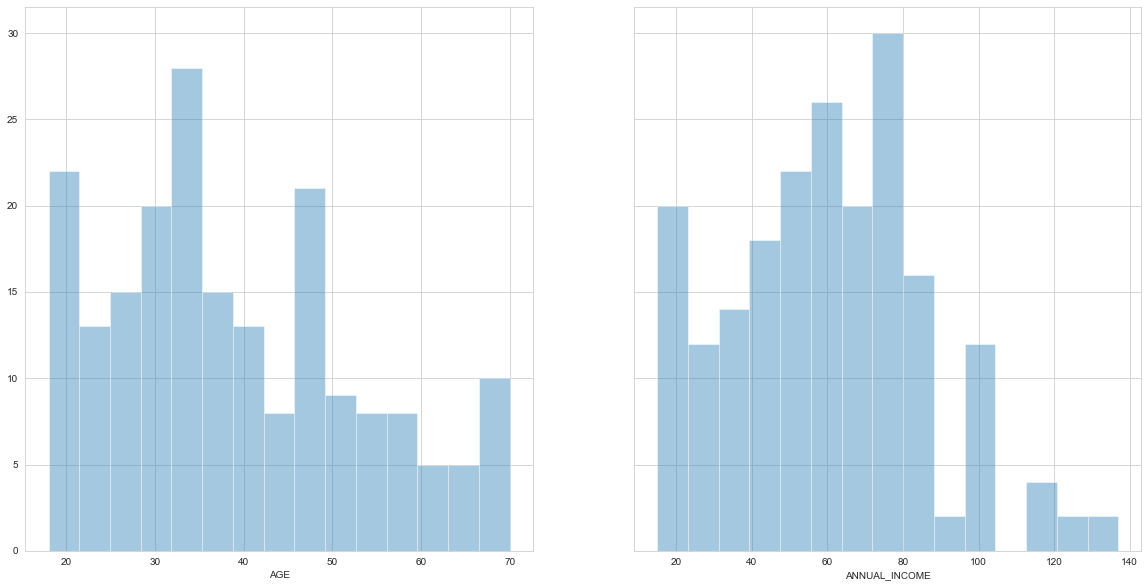

In [188]:
#users age and income
fig, ax = plt.subplots(1,2, sharey=True)

fig.set_size_inches(20,10)

#plot income histogram
income_hist = df.groupby(['USER_ID'])['AGE'].mean()
sns.distplot(income_hist,ax=ax[0], kde=False, bins=15);

#plot income histogram
income_hist = df.groupby(['USER_ID'])['ANNUAL_INCOME'].mean()
sns.distplot(income_hist, ax=ax[1], kde=False, bins=15);

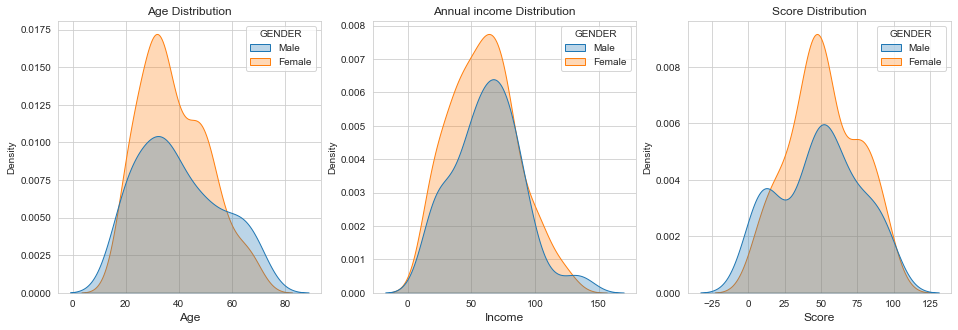

In [189]:
#age and income distribuction by gender
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16,5)

# age distribution
sns.kdeplot(data=df, x='AGE', hue='GENDER', fill=True, ax=ax[0], alpha=0.3)
ax[0].set_title('Age Distribution', fontsize=12)
ax[0].set_xlabel('Age', fontsize=12)

# annual income distribution
sns.kdeplot(data=df, x='ANNUAL_INCOME', hue='GENDER', fill=True, ax=ax[1], alpha=0.3)
ax[1].set_title('Annual income Distribution', fontsize=12)
ax[1].set_xlabel('Income', fontsize=12)

# score distribution
sns.kdeplot(data=df, x='SPENDING_SCORE', hue='GENDER', fill=True, ax=ax[2], alpha=0.3)
ax[2].set_title('Score Distribution', fontsize=12)
ax[2].set_xlabel('Score', fontsize=12)

plt.show()

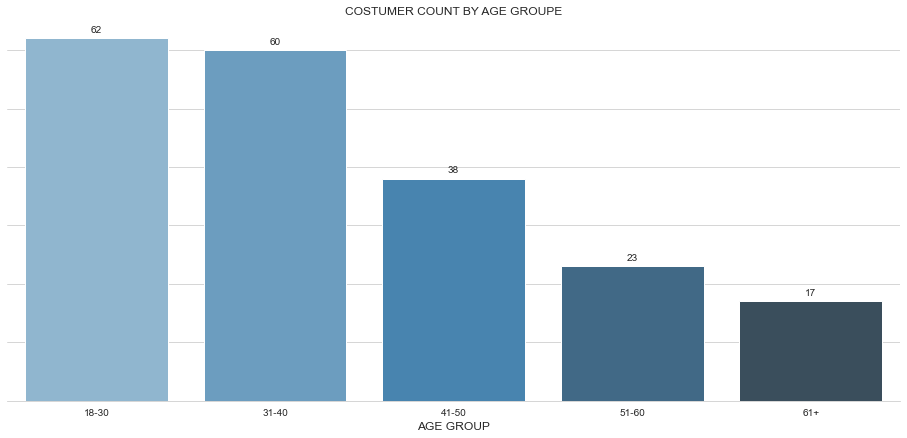

In [190]:
#show the sucess rate by offer
plt.figure(figsize=(16, 7))

#plot
#splot = sns.barplot(data=gender_age_sucess, x='variable', y='sucess', hue='gender', palette='Blues_d',ci=False)
splot = sns.countplot(x='AGE_GROUP', data=df, palette='Blues_d')

#labels and title
plt.xlabel('AGE GROUP', fontsize=12)
plt.title('COSTUMER COUNT BY AGE GROUPE', fontsize=12)

#hide borders, background and labels
sns.despine(left = True) #hide borders
sns.set_style("white") #set white background
splot.set(ylabel=None)  # remove the axis label
splot.set(yticklabels=[])  # remove the tick labels

#add annotations on each bar
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

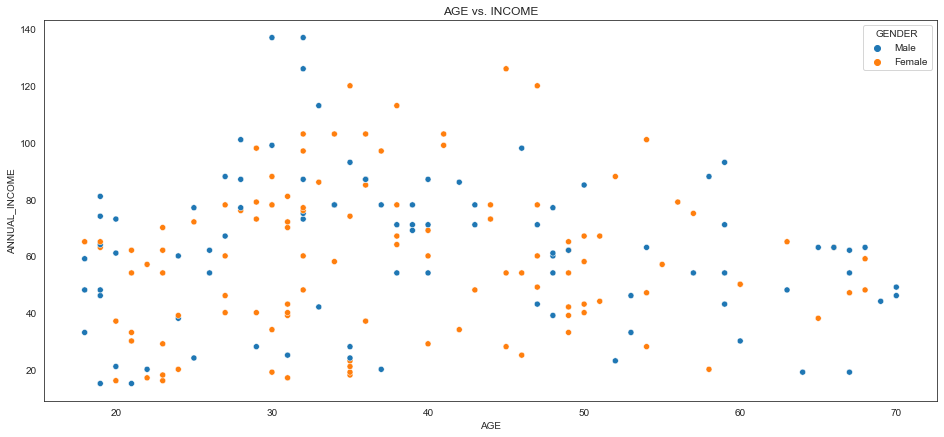

In [191]:
#show the sucess rate by offer
plt.figure(figsize=(16, 7))

#plot
#splot = sns.barplot(data=gender_age_sucess, x='variable', y='sucess', hue='gender', palette='Blues_d',ci=False)
splot = sns.scatterplot(data=df, x="AGE", y="ANNUAL_INCOME", hue="GENDER")

#labels and title
plt.title('AGE vs. INCOME', fontsize=12)

#hide borders, background and labels
sns.set_style("whitegrid") #set white background

plt.show()

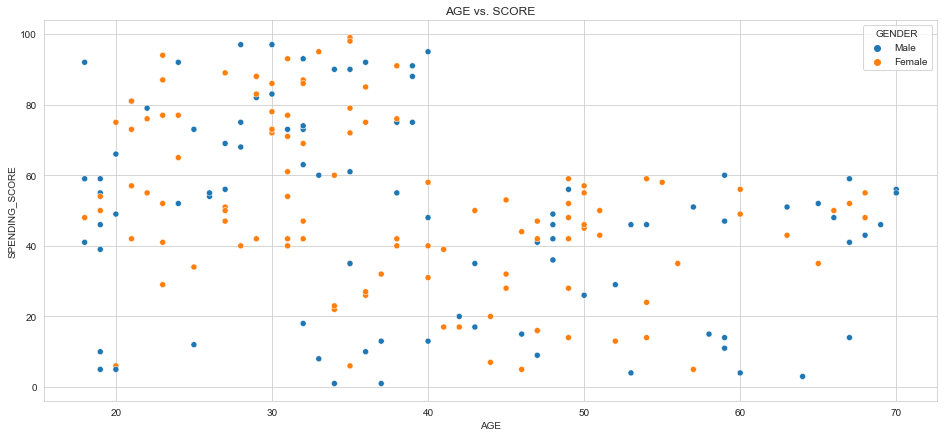

In [192]:
plt.figure(figsize=(16, 7))

#plot
splot = sns.scatterplot(data=df, x="AGE", y="SPENDING_SCORE", hue="GENDER")

#labels and title
plt.title('AGE vs. SCORE', fontsize=12)

#hide borders, background and labels
sns.set_style("whitegrid") #set white background

plt.show()

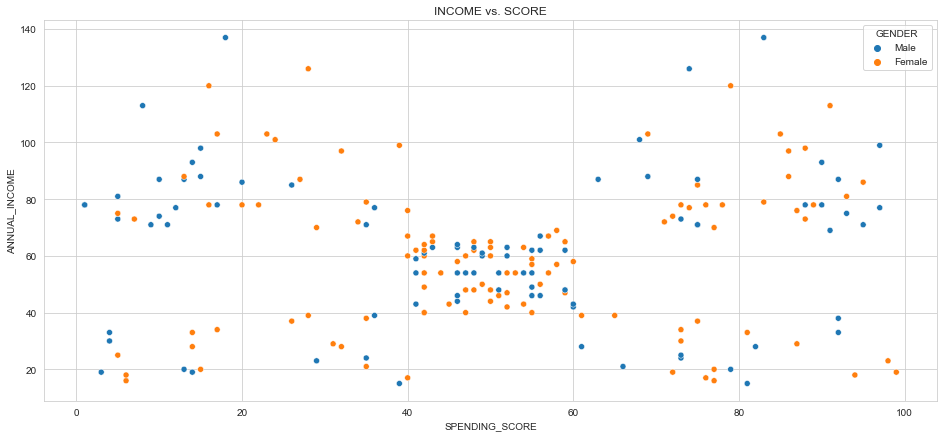

In [193]:
#show the sucess rate by offer
plt.figure(figsize=(16, 7))

#plot
#splot = sns.barplot(data=gender_age_sucess, x='variable', y='sucess', hue='gender', palette='Blues_d',ci=False)
splot = sns.scatterplot(data=df, x="SPENDING_SCORE", y="ANNUAL_INCOME", hue="GENDER")

#labels and title
plt.title('INCOME vs. SCORE', fontsize=12)

#hide borders, background and labels
sns.set_style("whitegrid") #set white background

plt.show()

In [194]:
def calculate_inertias(data):
    '''
    
    '''
    
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(data)
        kmeanModel.fit(data)

        inertias.append(kmeanModel.inertia_)
        
        mapping1[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                           'euclidean'), axis=1)) / data.shape[0]
        mapping2[k] = kmeanModel.inertia_
        
    return inertias, mapping1, mapping2, K

In [195]:
def optimal_number_of_clusters(inertias):
    '''
    Find the best number of clusters
    
    INPUT:
    
    '''
    x1, y1 = 1, inertias[0]
    x2, y2 = 9, inertias[len(inertias)-1]

    distances = []
    for i in range(len(inertias)):
        x0 = i+2
        y0 = inertias[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2, x1, y1, x2, y2

In [196]:
score_age_data = df[['AGE', 'SPENDING_SCORE']].to_numpy()
income_age_data = df[['AGE', 'ANNUAL_INCOME']].to_numpy()
income_score_data = df[['SPENDING_SCORE', 'ANNUAL_INCOME']].to_numpy()

inertias, mapping1, mapping2, K = calculate_inertias(income_score_data)
n, x1, y1, x2, y2 = optimal_number_of_clusters(inertias)

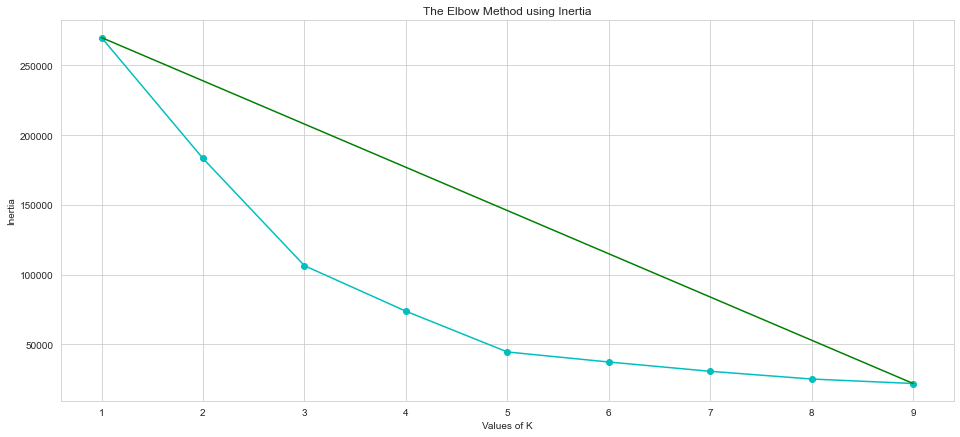

In [197]:
plt.figure(figsize=(16, 7))

plt.plot(K, inertias, 'c-o')
plt.plot([x2, x1], [y2,y1], color='g') # linha verde

plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.show()

In [198]:
df.head()
clustering_df = df[['AGE', 'ANNUAL_INCOME', 'SPENDING_SCORE', 'USER_ID']]

#### K-Means Clustering

The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. There are many different types of clustering methods, but k-means is one of the oldest and most approachable.

#### What Is Clustering?
Clustering is a set of techniques used to partition data into groups, or clusters. Clusters are loosely defined as groups of data objects that are more similar to other objects in their cluster than they are to data objects in other clusters. In practice, clustering helps identify two qualities of data:

- Meaningfulness
- Usefulness

**Meaningful clusters** expand domain knowledge. For example, in the medical field, researchers applied clustering to gene expression experiments. The clustering results identified groups of patients who respond differently to medical treatments.

**Useful clusters**, on the other hand, serve as an intermediate step in a data pipeline. For example, businesses use clustering for customer segmentation. The clustering results segment customers into groups with similar purchase histories, which businesses can then use to create targeted advertising campaigns.

In [199]:
#run the algorithm
algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300, 
                        tol=0.0001, random_state=42, algorithm='elkan') )

#fit the algorithm
algorithm.fit(income_score_data)

#label
labels2 = algorithm.labels_

#centroids
centroids2 = algorithm.cluster_centers_

In [202]:
clustering_df.head()

,AGE,ANNUAL_INCOME,SPENDING_SCORE,USER_ID
0,19,15,39,1
1,21,15,81,2
2,20,16,6,3
3,23,16,77,4
4,31,17,40,5


In [201]:
plt.figure(figsize=(16, 8))

ax = sns.scatterplot(data=df, x='SPENDING_SCORE', y='ANNUAL_INCOME', hue='CLUSTERS', palette="deep", alpha=0.4)
ax = plt.scatter(x=centroids2[: , 0], y=centroids2[: , 1] , s = 100)

plt.title('ANNUAL_INCOME vs. SPENDING_SCORE')
plt.xlabel('SPENDING_SCORE')

plt.show()

ValueError: Could not interpret value `CLUSTERS` for parameter `hue`

<Figure size 1152x576 with 0 Axes>